# Kernel Functions Profiling

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)

In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# RTApp configurator for generation of PERIODIC tasks
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace

# Target Configuration

In [26]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"    : 'android',
    "board"       : 'juno',
    "host"        : '10.169.36.25',

    # Folder where all the results will be collected
    "results_dir" : "TraceAnalysis_FunctionsProfiling",

    # Define devlib modules to load
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "functions" : [
            "pick_next_task_fair",
            "select_task_rq_fair",
            "enqueue_task_fair",
            "update_curr_fair",
            "dequeue_task_fair",
            
            # for tests
            "scheduler_timeout",
            "tick_sched_timer",
            "tick_sched_do_timer",
            "schedtune_cpu_boost",
            "schedtune_task_boost",
            "schedtune_prefer_idle",
            "schedtune_enqueue_task",
            "schedtune_dequeue_task",
        ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],
    
    # Comment this line to calibrate RTApp in your own platform
    "rtapp-calib" :  {"0": 360, "1": 142, "2": 138, "3": 352, "4": 352, "5": 353},
}

In [27]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

05:17:24  INFO    :         Target - Using base path: /data/lisa_fork/lisa
05:17:24  INFO    :         Target - Loading custom (inline) target configuration
05:17:24  DEBUG   :         Target - Target configuration {'platform': 'android', 'host': '10.169.36.25', 'ftrace': {'buffsize': 102400, 'functions': ['pick_next_task_fair', 'select_task_rq_fair', 'enqueue_task_fair', 'update_curr_fair', 'dequeue_task_fair', 'scheduler_timeout', 'tick_sched_timer', 'tick_sched_do_timer', 'schedtune_cpu_boost', 'schedtune_task_boost', 'schedtune_prefer_idle', 'schedtune_enqueue_task', 'schedtune_dequeue_task']}, 'board': 'juno', 'rtapp-calib': {'1': 142, '0': 360, '3': 352, '2': 138, '5': 353, '4': 352}, 'exclude_modules': ['hwmon'], 'tools': ['trace-cmd', 'rt-app'], 'results_dir': 'TraceAnalysis_FunctionsProfiling'}
05:17:24  INFO    :         Target - External tools using:
05:17:24  INFO    :         Target -    ANDROID_HOME: /home/zhifei/zyang/android-sdk-linux
05:17:24  INFO    :         Target 

# Workload Execution and Functions Profiling Data Collection

In [28]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [29]:
experiment(te)

05:17:32  INFO    :          WlGen - Setup new workload ramp
05:17:32  DEBUG   :          WlGen - Setup step [postrun] callback to [__postrun] function
05:17:32  DEBUG   :          WlGen - Configuring a profile-based workload...
05:17:32  DEBUG   :          RTApp - ref on big cpu: 1
05:17:32  INFO    :          RTApp - Workload duration defined by longest task
05:17:32  INFO    :          RTApp - Default policy: SCHED_OTHER
05:17:32  INFO    :          RTApp - ------------------------
05:17:32  INFO    :          RTApp - task [ramp], sched: using default policy
05:17:32  INFO    :          RTApp -  | calibration CPU: 1
05:17:32  INFO    :          RTApp -  | loops count: 1
05:17:32  INFO    :          RTApp - + phase_000001: duration 0.500000 [s] (5 loops)
05:17:32  INFO    :          RTApp - |  period   100000 [us], duty_cycle  60 %
05:17:32  INFO    :          RTApp - |  run_time  60000 [us], sleep_time  40000 [us]
05:17:32  INFO    :          RTApp - + phase_000002: duration 0.50000

# Parse Trace and Profiling Data

In [30]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

05:17:44  INFO    : Content of the output folder /data/lisa_fork/lisa/results/TraceAnalysis_FunctionsProfiling


/data/lisa_fork/lisa/results/TraceAnalysis_FunctionsProfiling
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── rt-app-ramp_1-0.log
├── rt-app-ramp_1-1.log
├── rt-app-ramp_2-2.log
├── trace.dat
├── trace.raw.txt
├── trace.stats
└── trace.txt

0 directories, 11 files


In [31]:
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

05:17:44  INFO    : LITTLE cluster max capacity: 447


In [32]:
trace = Trace(platform, res_dir, events=[])

05:17:44  DEBUG   : Loading [sched] events from trace in [/data/lisa_fork/lisa/results/TraceAnalysis_FunctionsProfiling]...
05:17:44  DEBUG   : Parsing events: []
05:17:44  INFO    : Parsing FTrace format...
05:17:44  DEBUG   : Loading functions profiling data from [/data/lisa_fork/lisa/results/TraceAnalysis_FunctionsProfiling/trace.stats]...
05:17:44  DEBUG   : Events found on trace:
05:17:44  INFO    : Trace contains only functions stats
05:17:44  INFO    : Collected events spans a 0.000 [s] time interval
05:17:44  INFO    : Set plots time range to (0.000000, 0.000000)[s]
05:17:44  DEBUG   : Registering [<trace.Trace object at 0x7fcd498e52d0>] local data frames
05:17:44  DEBUG   :    functions_stats
05:17:44  DEBUG   :    trace_event
05:17:44  DEBUG   :       Analysis - Analysis: /data/lisa_fork/lisa/libs/utils/analysis
05:17:44  DEBUG   :       Analysis - Syspath: ['/data/lisa_fork/lisa/libs/utils/analysis', '/data/lisa_fork/lisa/libs/utils/analysis', '/data/lisa_fork/lisa/libs/util

# Report Functions Profiling Data

In [33]:
# Get the DataFrame for the specified list of kernel functions
df = trace.data_frame.functions_stats(['enqueue_task_fair', 'dequeue_task_fair'])
df

hits     avg     time     s_2
0 dequeue_task_fair   266  17.626  4688.70  63.100
  enqueue_task_fair    45  10.384   467.30  30.567
1 dequeue_task_fair   548   8.912  4883.86  18.460
  enqueue_task_fair   492   7.903  3888.70  11.731
2 dequeue_task_fair   405  10.451  4232.86  27.577
  enqueue_task_fair   172   7.900  1358.80  13.977
3 dequeue_task_fair   178  12.399  2207.16  56.776
  enqueue_task_fair    60  10.218   613.10  27.021
4 dequeue_task_fair   425  11.096  4715.86  63.129
  enqueue_task_fair    35  11.679   408.78  26.920
5 dequeue_task_fair    82  14.355  1177.16  69.660
  enqueue_task_fair    30   7.992   239.76  16.436

In [34]:
# Get the DataFrame for the single specified kernel function
df = trace.data_frame.functions_stats('select_task_rq_fair')
df

,,hits,avg,time,s_2
0,select_task_rq_fair,117,16.149,1889.46,113.202
1,select_task_rq_fair,441,7.313,3225.14,74.198
2,select_task_rq_fair,343,9.712,3331.48,104.951
3,select_task_rq_fair,108,15.209,1642.64,191.652
4,select_task_rq_fair,38,18.227,692.66,277.024
5,select_task_rq_fair,26,19.659,511.14,482.759


# Plot Functions Profiling Data

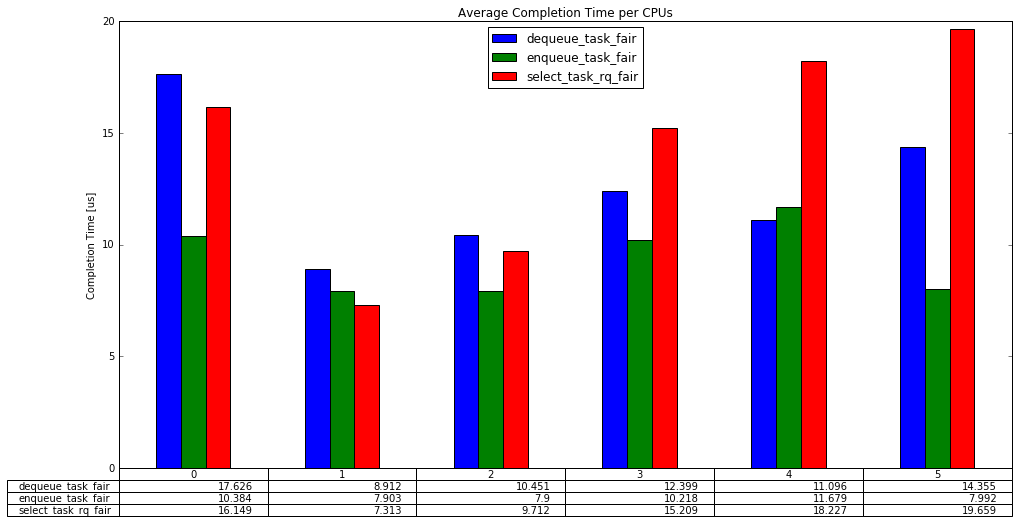

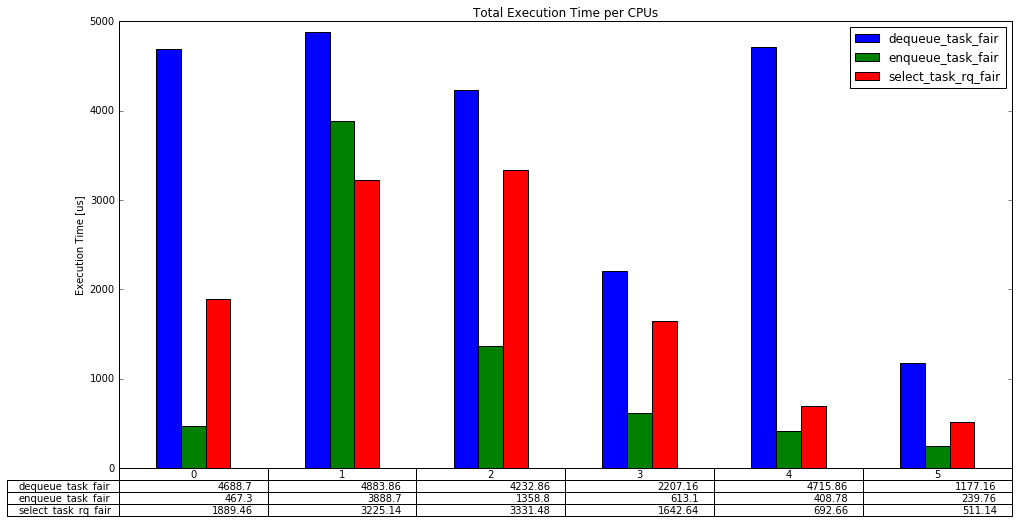

In [35]:
# Plot Average and Total execution time for the specified
# list of kernel functions
trace.analysis.functions.plotProfilingStats(
    functions = [
        'select_task_rq_fair',
        'enqueue_task_fair',
        'dequeue_task_fair'
    ],
    metrics = [
        'avg',
        'time',
    ]
)

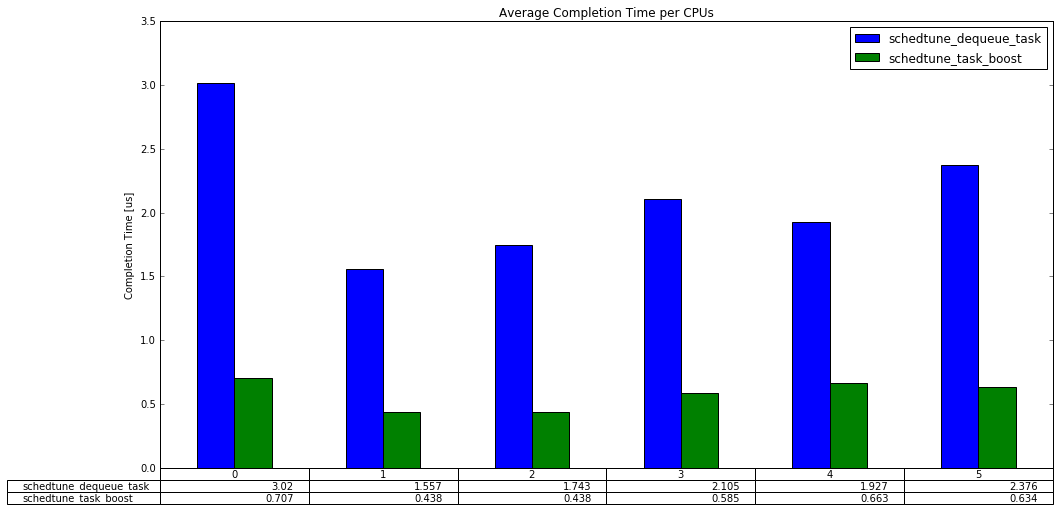

In [39]:
# Plot Average execution time for the single specified kernel function
trace.analysis.functions.plotProfilingStats(
    functions = [
            "scheduler_timeout",
            "schedtune_dequeue_task",
            "schedtune_task_boost",        
                ]
)